In [86]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, Flatten, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score


In [87]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [74]:
training_labels = to_categorical(np.array(train['Stance']))
testing_labels = to_categorical(np.array(test['Stance']))

In [75]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combinedText'])
train_sequence = tokenizer.texts_to_sequences(train['combinedText'])
test_sequence = tokenizer.texts_to_sequences(test['combinedText'])

In [77]:
longest_sequence = 200
train_pad = pad_sequences(train_sequence, maxlen=longest_sequence, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=longest_sequence, padding='post', truncating='post')

In [90]:
embedding_dim = 200
in_file = '../data/glove/glove.6B.200d.txt'
out_file = '../data/glove.200d.word2vec.txt'

glove2word2vec(in_file, out_file)
w2v = KeyedVectors.load_word2vec_format(out_file, binary=False)


In [91]:
vocab = tokenizer.word_index.keys()
embedding_matrix = np.zeros((len(vocab)+1, embedding_dim))

embedding_matrix[0] = np.random.random((1, embedding_dim))
for i, word in enumerate(vocab, 1):
    try:
        embedding_matrix[i] = w2v[word]
    except KeyError as e:
        embedding_matrix[i] = np.random.random((1, embedding_dim))

In [80]:
train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, training_labels, random_state = 42, test_size = 0.15)

In [ ]:
# Hyperparameters to tune: 
# height/width: 3x3, 5x5, 7x7
# MaxPooling vs Max-Over-Time Pooling
# Different drop-out rates
# Seqeuence length
kernel_sizes = [3, 5, 7]
dropouts = [0.2, 0.3, 0.4]
sequences = [100, 200, 300, 500] 

best_model = Sequential()
best_accuracy = 0
for sequence_length in sequences:
    train_pad = pad_sequences(train_sequence, maxlen=sequence_length, padding='post', truncating='post')
    test_pad = pad_sequences(test_sequence, maxlen=sequence_length, padding='post', truncating='post')
    train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, training_labels, random_state = 42, test_size = 0.15)
    for kernel in kernel_sizes:
        for dropout in dropouts:
            keras.backend.clear_session()

            model = Sequential()
            model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                                output_dim=embedding_dim,
                                embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                input_length=sequence_length,
                                trainable=True,
                                name='embedding_layer',
                                ))
            model.add(Conv1D(filters=256, kernel_size=kernel, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(filters=128, kernel_size=kernel, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu'))
            model.add(GlobalMaxPooling1D())
#             model.add(Flatten())
            model.add(Dense(embedding_dim, activation='relu'))
            model.add(Dropout(dropout))
            model.add(Dense(4, activation='softmax'))
#             print(model.summary())
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(train_pad, train_labels, epochs=10, batch_size=200, validation_data=(val_pad, val_labels))

            _, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
            print("Test Set Accuracy = {:.4f}".format(accuracy))

            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_model = model
                best_model_string = f"Best Model has seq_length={sequence_length}, kernel={kernel} and dropout={dropout}"
                print(best_model_string) 

In [3]:
word_count = lambda x:len(x.split())
train['text_wc'] = train['combinedText'].apply(word_count)

p = 75.0

print(' Summary :{} % of the summaries have a length less than or equal to {}'.format(p, np.percentile(train['text_wc'], p)))
MAX_LEN = int(np.percentile(train['text_wc'], p))

 Summary :75.0 % of the summaries have a length less than or equal to 478.0


In [88]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


oversample = RandomOverSampler(sampling_strategy={0:round(36545*0.25), 1: round(36545*0.5), 2: round(36545*0.5)})
undersample = RandomUnderSampler(sampling_strategy={3: round(36545*0.5)})

train_over, training_over_labels = oversample.fit_resample(train, train['Stance'])

print(Counter(training_over_labels))

train_combined_sampling, training_combined_sampling_labels = undersample.fit_resample(train_over, training_over_labels)

print(f"Combined:{Counter(training_combined_sampling_labels)}")

training_combined_labels = to_categorical(np.array(training_combined_sampling_labels))
testing_labels = to_categorical(np.array(test['Stance']))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combinedText'])
test_sequence = tokenizer.texts_to_sequences(test['combinedText'])
train_combined_sequence = tokenizer.texts_to_sequences(train_combined_sampling['combinedText'])


Counter({3: 36545, 1: 18272, 2: 18272, 0: 9136})
Combined:Counter({1: 18272, 2: 18272, 3: 18272, 0: 9136})


/srv/jupyter_python3-extras/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of each label')

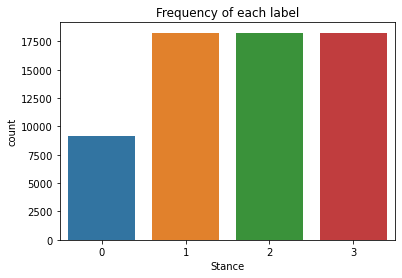

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(training_combined_sampling_labels)
plt.xlabel('Stance')
plt.title("Frequency of each label")

In [5]:
train_combined_pad = pad_sequences(train_combined_sequence, maxlen=MAX_LEN, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=MAX_LEN, padding='post', truncating='post')
train_combined_pad, val_combined_pad, train_combined_labels, val_combined_labels = train_test_split(train_combined_pad, training_combined_labels, random_state = 42, test_size = 0.15)


In [9]:
kernel_sizes = [3, 5, 7]
dropouts = [0.2, 0.3, 0.4]

best_model = Sequential()
best_accuracy = 0
for kernel in kernel_sizes:
    for dropout in dropouts:
        keras.backend.clear_session()
        
        print(f"Current Model is: kernel={kernel}, dropout={dropout}")

        model = Sequential()
        model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                            output_dim=embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_LEN,
                            trainable=True,
                            name='embedding_layer',
                            ))
        model.add(Conv1D(filters=256, kernel_size=kernel, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=kernel, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu'))
        model.add(GlobalMaxPooling1D())
        #             model.add(Flatten())
        model.add(Dense(embedding_dim, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(4, activation='softmax'))
        #             print(model.summary())
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(train_combined_pad, train_combined_labels, epochs=10, batch_size=200, validation_data=(val_combined_pad, val_combined_labels))

        _, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
        print("Test Set Accuracy = {:.4f}".format(accuracy))

        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_model = model
            best_model_string = f"Best Model has kernel={kernel} and dropout={dropout}"
            print(best_model_string) 

Current Model is: kernel=3, dropout=0.2


Train on 54359 samples, validate on 9593 samples
Epoch 1/10
54359/54359 [==============================] - 133s 2ms/step - loss: 0.8942 - accuracy: 0.6077 - val_loss: 0.5760 - val_accuracy: 0.7729
Epoch 2/10
54359/54359 [==============================] - 173s 3ms/step - loss: 0.3939 - accuracy: 0.8493 - val_loss: 0.3047 - val_accuracy: 0.8893
Epoch 3/10
54359/54359 [==============================] - 198s 4ms/step - loss: 0.2319 - accuracy: 0.9154 - val_loss: 0.2100 - val_accuracy: 0.9233
Epoch 4/10
54359/54359 [==============================] - 154s 3ms/step - loss: 0.1552 - accuracy: 0.9452 - val_loss: 0.1690 - val_accuracy: 0.9409
Epoch 5/10
54359/54359 [==============================] - 125s 2ms/step - loss: 0.1085 - accuracy: 0.9639 - val_loss: 0.1442 - val_accuracy: 0.9494
Epoch 6/10
54359/54359 [==============================] - 127s 2ms/step - loss: 0.0805 - accuracy: 0.9723 - val_loss: 0.1156 - val_accuracy: 0.9612
Epoch 7/10
54359/5435

In [11]:
best_model_string

'Best Model has kernel=3 and dropout=0.4'

In [ ]:
# BEST MODEL

keras.backend.clear_session()
sequence_length = 200;
kernel = 3
dropout = 0.2;
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True,
                    name='embedding_layer',
                    ))
model.add(Conv1D(filters=256, kernel_size=kernel, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=kernel, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu'))
model.add(GlobalMaxPooling1D())
#             model.add(Flatten())
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(4, activation='softmax'))
#             print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
fit_model = model.fit(train_pad, train_labels, epochs=10, batch_size=200, validation_data=(val_pad, val_labels))

_, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
print("Test Set Accuracy = {:.4f}".format(accuracy))

In [ ]:
# RUNNING AND SAVING THE BEST TRAINED MODELS

In [81]:
# V1
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    input_length=longest_sequence,
                    trainable=True,
                    name='embedding_layer',
                    ))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))
#             print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_pad, train_labels, epochs=10, batch_size=200, validation_data=(val_pad, val_labels))

y_predict, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
print("Test Set Accuracy = {:.4f}".format(accuracy))
model.save('../data/cnn_v1.model')

Train on 42476 samples, validate on 7496 samples
Epoch 1/10
42476/42476 [==============================] - 26s 603us/step - loss: 0.7418 - accuracy: 0.7385 - val_loss: 0.5608 - val_accuracy: 0.7883
Epoch 2/10
42476/42476 [==============================] - 26s 602us/step - loss: 0.4724 - accuracy: 0.8176 - val_loss: 0.4015 - val_accuracy: 0.8474
Epoch 3/10
42476/42476 [==============================] - 26s 604us/step - loss: 0.3256 - accuracy: 0.8753 - val_loss: 0.3113 - val_accuracy: 0.8830
Epoch 4/10
42476/42476 [==============================] - 26s 605us/step - loss: 0.2358 - accuracy: 0.9101 - val_loss: 0.2476 - val_accuracy: 0.9096
Epoch 5/10
42476/42476 [==============================] - 26s 609us/step - loss: 0.1837 - accuracy: 0.9294 - val_loss: 0.2302 - val_accuracy: 0.9146
Epoch 6/10
42476/42476 [==============================] - 26s 611us/step - loss: 0.1464 - accuracy: 0.9434 - val_loss: 0.2105 - val_accuracy: 0.9261
Epoch 7/10
42476/42476 [==============================] -

In [56]:
# V2
keras.backend.clear_session()
sequence_length=100
train_pad = pad_sequences(train_sequence, maxlen=sequence_length, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=sequence_length, padding='post', truncating='post')
train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, training_labels, random_state = 42, test_size = 0.15)
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True,
                    name='embedding_layer',
                    ))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_pad, train_labels, epochs=10, batch_size=200, validation_data=(val_pad, val_labels))

y_predict, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
print("Test Set Accuracy = {:.4f}".format(accuracy))
model.save('../data/cnn_v2.model')

Train on 42476 samples, validate on 7496 samples
Epoch 1/10
42476/42476 [==============================] - 14s 334us/step - loss: 0.6926 - accuracy: 0.7508 - val_loss: 0.5040 - val_accuracy: 0.8090
Epoch 2/10
42476/42476 [==============================] - 14s 329us/step - loss: 0.4190 - accuracy: 0.8424 - val_loss: 0.3395 - val_accuracy: 0.8761
Epoch 3/10
42476/42476 [==============================] - 14s 331us/step - loss: 0.2666 - accuracy: 0.9026 - val_loss: 0.2791 - val_accuracy: 0.9009
Epoch 4/10
42476/42476 [==============================] - 14s 333us/step - loss: 0.1863 - accuracy: 0.9319 - val_loss: 0.2065 - val_accuracy: 0.9277
Epoch 5/10
42476/42476 [==============================] - 14s 334us/step - loss: 0.1271 - accuracy: 0.9532 - val_loss: 0.1911 - val_accuracy: 0.9353
Epoch 6/10
42476/42476 [==============================] - 14s 335us/step - loss: 0.0918 - accuracy: 0.9662 - val_loss: 0.2129 - val_accuracy: 0.9349
Epoch 7/10
42476/42476 [==============================] -

In [92]:
# V3
keras.backend.clear_session()

MAX_LEN = 478
train_combined_pad = pad_sequences(train_combined_sequence, maxlen=MAX_LEN, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=MAX_LEN, padding='post', truncating='post')
train_combined_pad, val_combined_pad, train_combined_labels, val_combined_labels = train_test_split(train_combined_pad, training_combined_labels, random_state = 42, test_size = 0.15)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=True,
                    name='embedding_layer',
                    ))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_combined_pad, train_combined_labels, epochs=10, batch_size=200, validation_data=(val_combined_pad, val_combined_labels))

y_predict, accuracy = model.evaluate(test_pad, testing_labels, batch_size=200)
print("Test Set Accuracy = {:.4f}".format(accuracy))
model.save('../data/cnn_v3.model')

Train on 54359 samples, validate on 9593 samples
Epoch 1/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.8947 - accuracy: 0.6127 - val_loss: 0.4646 - val_accuracy: 0.8220
Epoch 2/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.3832 - accuracy: 0.8590 - val_loss: 0.3049 - val_accuracy: 0.8873
Epoch 3/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.2387 - accuracy: 0.9150 - val_loss: 0.2375 - val_accuracy: 0.9156
Epoch 4/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.1631 - accuracy: 0.9430 - val_loss: 0.1683 - val_accuracy: 0.9418
Epoch 5/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.1187 - accuracy: 0.9580 - val_loss: 0.1879 - val_accuracy: 0.9340
Epoch 6/10
54359/54359 [==============================] - 74s 1ms/step - loss: 0.0953 - accuracy: 0.9674 - val_loss: 0.1397 - val_accuracy: 0.9565
Epoch 7/10
54359/54359 [==============================] - 74s 1ms/ste

In [93]:
y_predict = model.predict(test_pad)
y_pred_competition = y_predict.argmax(axis=-1)
y_classes = []

for i in range(len(y_pred_competition)):
    if y_pred_competition[i] == 0: y_classes.append("disagree")
    
    if y_pred_competition[i] == 1: y_classes.append("agree")
    
    if y_pred_competition[i] == 2: y_classes.append("discuss")
    
    if y_pred_competition[i] == 3: y_classes.append("unrelated")
    
answers = pd.DataFrame()
answers['Headline'] = test['Headline']
answers['Body ID'] = test['Body ID']
answers['Stance'] = y_classes
answers.to_csv('../data/answer_cnn_v3.csv', index=False, encoding='utf-8')


Accuracy: 0.6573407311218668
Precision: [0.16239316 0.21569293 0.38770413 0.81839389]
Recall: [0.02725968 0.33368366 0.45206093 0.76478282]
F1_Scores: [0.04668305 0.26201774 0.41741649 0.79068064]


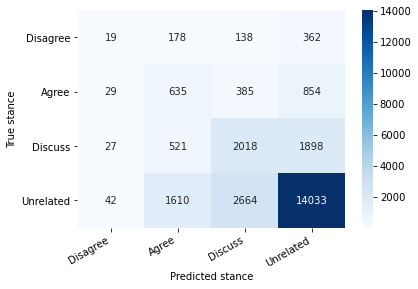

In [94]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

class_names=['Disagree', 'Agree', 'Discuss', 'Unrelated']
cm = confusion_matrix(test['Stance'], y_pred_competition)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

accuracy = accuracy_score(test['Stance'], y_pred_competition)
print(f'Accuracy: {accuracy}')

precision = precision_score(test['Stance'], y_pred_competition, average=None)
print(f'Precision: {precision}')

recall = recall_score(test['Stance'], y_pred_competition, average=None)
print(f'Recall: {recall}')

f1_scores=f1_score(test['Stance'], y_pred_competition, average=None)
print(f'F1_Scores: {f1_scores}')